##Análise dos dados sobre educação superior do inep. Dados foram retirados [aqui](https://drive.google.com/drive/folders/1DrEowqNixud3IlHMO6YTgZqQ2PvgvTpk?usp=sharing)


#Instalando e importanto bibliotecas  

In [ ]:
!pip install dask[dataframe]

In [4]:
import pandas as pd
import requests, zipfile, io
import dask.dataframe as dd
import seaborn as sns
import matplotlib.pyplot as plt
import numpy as np
import warnings
warnings.filterwarnings("ignore")

#Extraindo os dados

Os dados por serem grandes foram armazenados no google drive. Pegaremos os dados de lá

In [1]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


Carregando os dados na variável data

In [8]:
data = dd.read_csv("/content/drive/MyDrive/Dados_INEP/Aluno.csv/*"
                    ,encoding = "ISO-8859-1",dtype={'CO_ALUNO': 'object'})


In [9]:
data.columns

Index(['CO_IES', 'CO_ALUNO', 'Cat_Adm', 'CO_CURSO', 'Nivel_Aca', 'Cor/Raca',
       'Genero', 'Cota_Racial', 'Apoio_Social', 'Ano'],
      dtype='object')

As colunas são as seguintes :

* CO_ALUNO = Codigo identificador único do aluno

* CO_IES = Codigo identificador da IES que o aluno esta matriculado 

* Cat_Adm = Categoria Administrativa do IES que o aluno esta matriculado.

* CO_CURSO = Curso no qual o aluno esta matriculado.

* Nivel_Aca = Nivél Acadêmico do Aluno( Graduaçao, Curso Especial)

* Cor/Raca = Cor/Raça a qual o aluno se identifica

* Genero = Genero que o aluno se identifica

* Cota_Racial = Indica se o aluno ingressou na faculdade por meio de cotas de cunho etnico

* Apoio_Social = Indica se o aluno recebeu algum apoio de cunho social.

* Ano = Ano que o dado foi coletado.


#Análise

Vamos primeiro, ver quantos dados diferentes temos :

In [10]:
len(data)

113190205

Temos 113 milhões de entradas. É fácil entender que não temos uma quantidade semelhante de pessoas na faculdades, logo, alguns alunos são contados multiplas vezes, pois quem foi computado pelo INEP que ingressou em 2012 e conclui em 2017, foi contado uma vez a cada ano neste intervalo.

Vamos ter uma visão geral dos dados por ano, isto é, quantos alunos estão matriculados por ano no curso superior.

In [60]:
  data_estudantes= data.Ano.value_counts().compute()
  serie_estudantes = data_estudantes.sort_index(ascending= True).values
  anos =list(range(2009,2020))


In [61]:
# Função para facilitar a criação de graficos
def plot_graph(titulo,eixoX,eixoY,eixoXTitulo,eixoYTitulo) :
  sns.set_style("whitegrid")
  fig = plt.figure(figsize=(16,8))
  ax = fig.add_subplot(111)
  fig.subplots_adjust(top=0.90)

  # Título e eixos x e y
  fig.suptitle(titulo, fontsize=16, fontweight='bold')
  ax.set_xlabel(eixoXTitulo,fontsize=14, labelpad=20)
  ax.set_ylabel(eixoYTitulo,fontsize=14, labelpad=20)

  sns.barplot(eixoX,
              eixoY,
              palette=sns.color_palette("BuGn_r",n_colors=len(eixoX) + 100))
  plt.show()



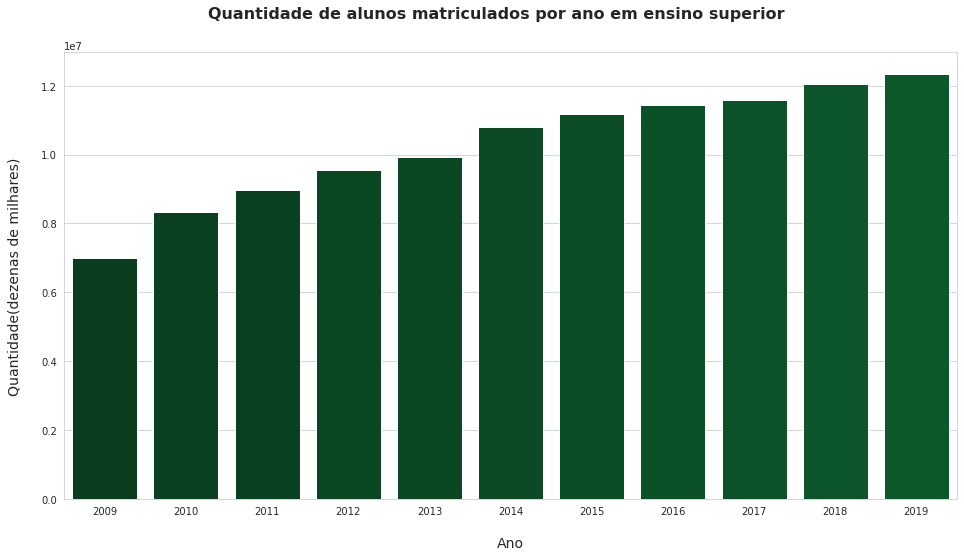

In [62]:
titulo = "Quantidade de alunos matriculados por ano em ensino superior"
eixoXTitulo = "Ano"
eixoYTitulo = "Quantidade(dezenas de milhares)"
eixoX = anos
eixoY = serie_estudantes
plot_graph(titulo,eixoX,eixoY,eixoXTitulo,eixoYTitulo)

Vamos fazer o mesmo, mas agora para apenas população que se declara Negro("Cor" =2 )

In [63]:
data_negro =data[data["Cor/Raca"] == 2]
serie_negro =data_negro.groupby(["Ano"])["Cor/Raca"].count().compute().values
serie_negro = serie_negro[1:]


In [64]:
# É importante notar que não existem nos dados que coletei numero de Pretos em 2009( algum erro no calculo), logo pegaremos apenas dados de 2010 pra frente
anos_negro = anos[1:]
anos_negro

[2010, 2011, 2012, 2013, 2014, 2015, 2016, 2017, 2018, 2019]

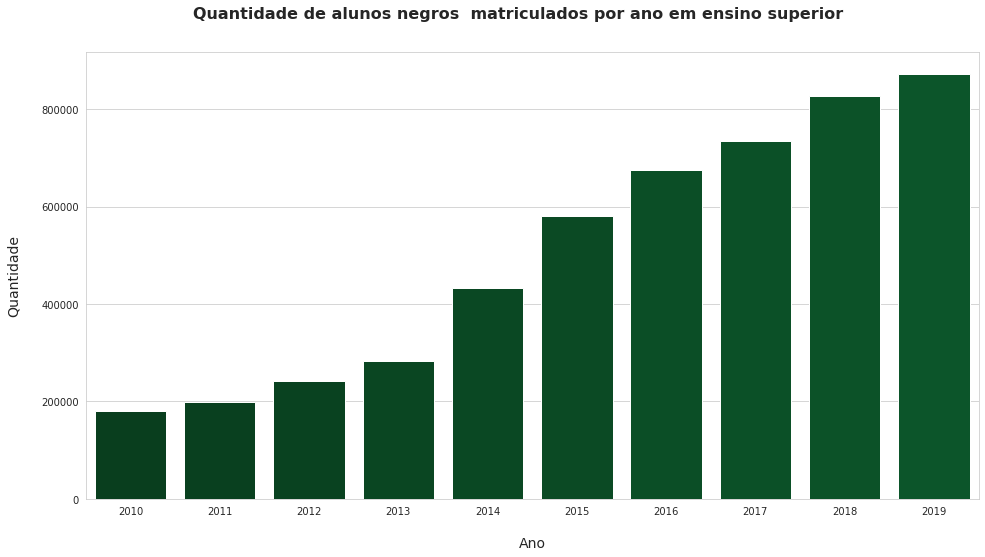

In [65]:
titulo = "Quantidade de alunos negros  matriculados por ano em ensino superior"
eixoXTitulo = "Ano"
eixoYTitulo = "Quantidade"
eixoX = anos_negro
eixoY = serie_negro
plot_graph(titulo,eixoX,eixoY,eixoXTitulo,eixoYTitulo)

Olhando para estes gráficos não se tem dimensão da quantidade de negros em ensino superior em relação aos demais. Faremos um gráfico de proporção para demonstrar isto.

In [66]:
serie_proporcao = (serie_negro/serie_estudantes[1:])*100


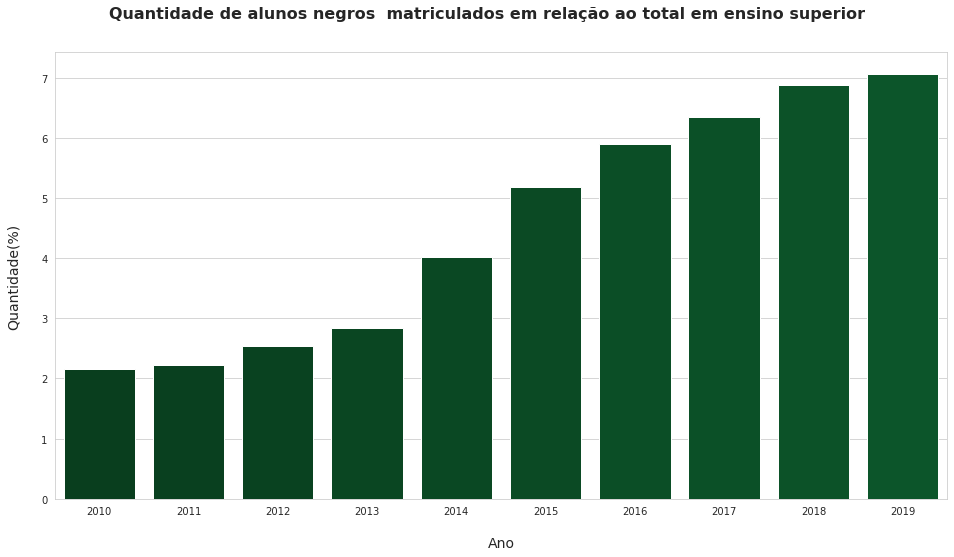

In [67]:
titulo = "Quantidade de alunos negros  matriculados em relação ao total em ensino superior"
eixoXTitulo = "Ano"
eixoYTitulo = "Quantidade(%)"
eixoX = anos_negro
eixoY = serie_proporcao
plot_graph(titulo,eixoX,eixoY,eixoXTitulo,eixoYTitulo)

Apenas 7% dos matriculados em 2019 são classificados negros, é um valor ínfimo. Vou calcular agora se este aumento foi ajudado pelas cotas, isto é, qual porcentagem dos alunos ingressantes negros entraram pela ajuda de cotas raciais.

In [68]:
data_negro_cota = data_negro[data_negro.Cota_Racial == 1].groupby(["Ano"])["Cota_Racial"].count()
serie_cota = data_negro_cota.compute().values
serie_cota = serie_cota[1:]

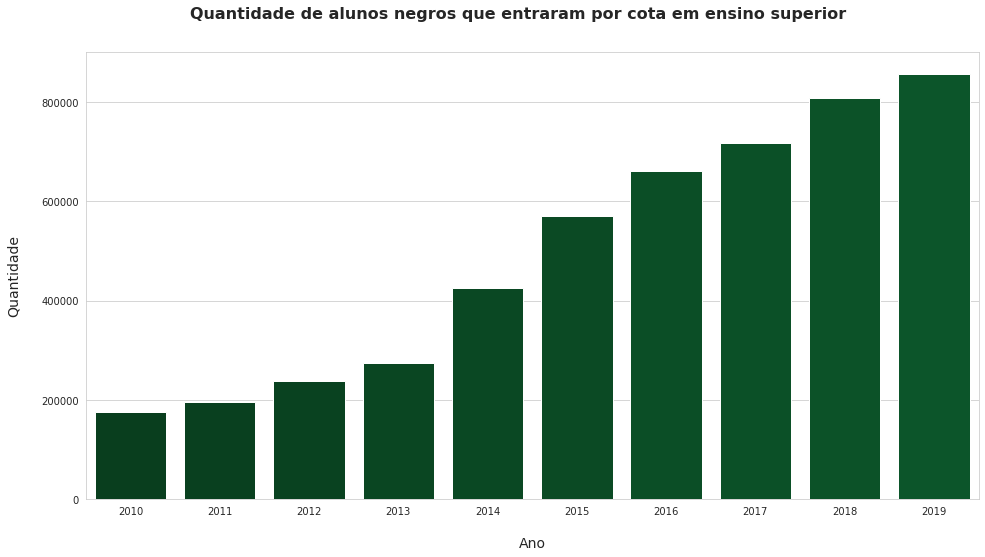

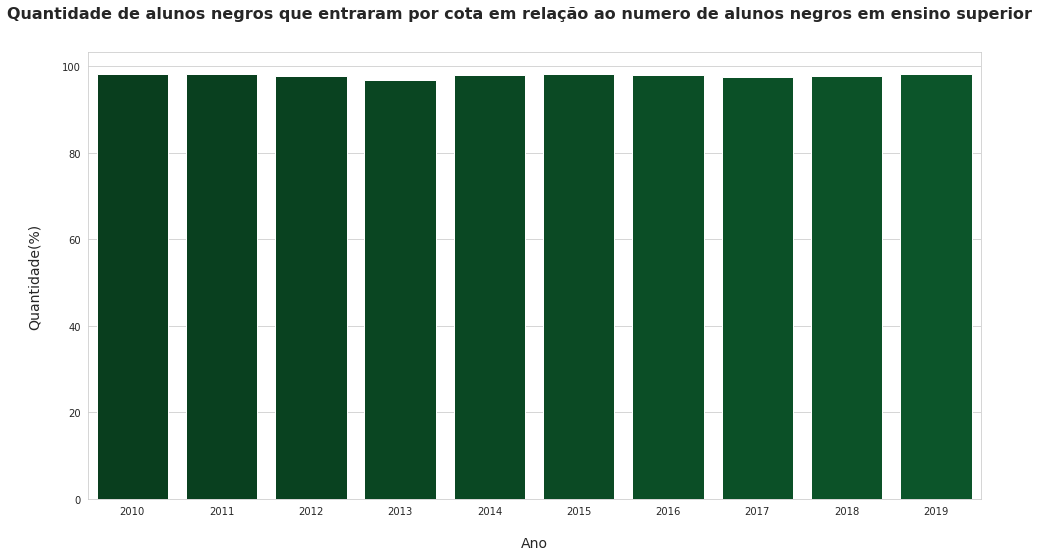

In [69]:
titulo = "Quantidade de alunos negros que entraram por cota em ensino superior"
eixoXTitulo = "Ano"
eixoYTitulo = "Quantidade"
eixoX = anos_negro
eixoY = serie_cota
plot_graph(titulo,eixoX,eixoY,eixoXTitulo,eixoYTitulo)

titulo = "Quantidade de alunos negros que entraram por cota em relação ao numero de alunos negros em ensino superior"
eixoXTitulo = "Ano"
eixoYTitulo = "Quantidade(%)"
eixoX = anos_negro
eixoY = (serie_cota/serie_negro)*100
plot_graph(titulo,eixoX,eixoY,eixoXTitulo,eixoYTitulo)

10% dos alunos negros entraram por cota no ano de 2019, valor superior aos 7% no ano. O curso  superior esta mais inclusivo com o tempo, entretando parece que vai estabilizar, e não continuar crescendo como é o ideal.

Uma ultima análise se refere ao número de negros em universidades públicas e privadas. Vamos ver como se comporta

In [70]:
data_negro_publi = data_negro[(data_negro["Cat_Adm"].isin([1,2,3]))].compute()
serie_negro_publi = data_negro_publi.groupby("Ano")["Cat_Adm"].count().values
            

In [71]:
serie_negro_priv_outros = serie_negro - serie_negro_publi[1:]


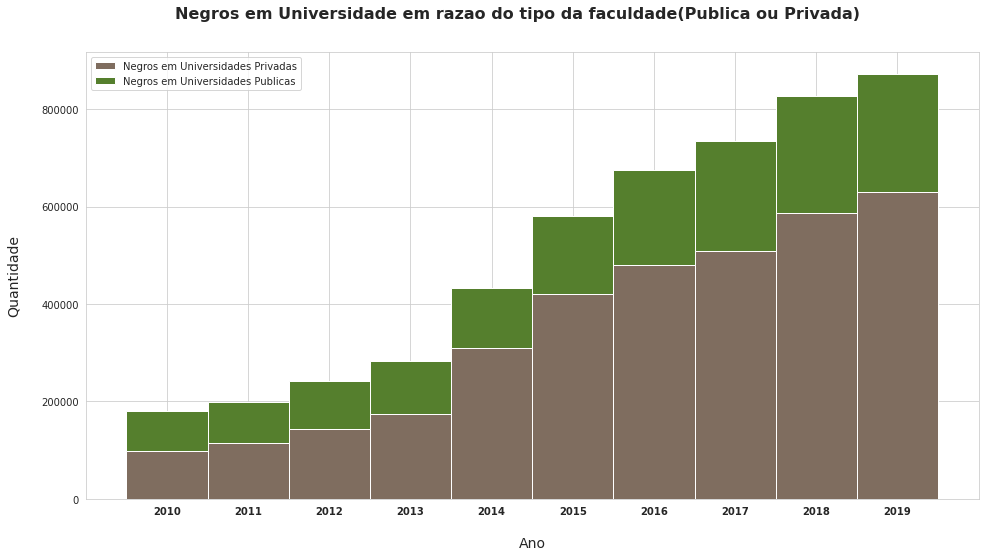

In [72]:
import numpy as np
# Values of each group
bars1 = serie_negro_priv_outros
bars2 = serie_negro_publi[1:]
 

fig = plt.figure(figsize=(16,8))
ax = fig.add_subplot(111)
fig.subplots_adjust(top=0.90)
fig.suptitle("Negros em Universidade em razao do tipo da faculdade(Publica ou Privada)", fontsize=16, fontweight='bold')
ax.set_xlabel("Ano",fontsize=14, labelpad=20)
ax.set_ylabel("Quantidade",fontsize=14, labelpad=20)

bars = np.add(bars1, bars2).tolist()

r = anos_negro
 
names = anos_negro
barWidth = 1
 
plt.bar(r, bars1, color='#7f6d5f', edgecolor='white', width=barWidth)
# Create green bars (middle), on top of the firs ones
plt.bar(r, bars2, bottom=bars1, color='#557f2d', edgecolor='white', width=barWidth)

 

plt.xticks(r, names, fontweight='bold')
ax.legend(["Negros em Universidades Privadas","Negros em Universidades Publicas"])
 
# Show graphic
plt.show()